# Sea Surface Temperature — NEMO GYRE

Analyse SST (`sosstsst`) from the GYRE simulation.
- Mean SST field
- SST temporal evolution
- Meridional SST gradient

In [1]:
from pathlib import Path

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import nc_time_axis  # noqa: F401 — registers cftime support in matplotlib

from gyre import load_output, load_mesh, interior_mask, cell_area, gyre_map

plt.rcParams.update({"font.size": 16, "axes.titlesize": 18, "axes.labelsize": 14})

OUTPUT_DIR = Path("../output")

## Load simulation output

Load the recombined grid_T file and mesh_mask. Cell widths `e1t`/`e2t`
provide area weighting for spatial averages, and `tmask` masks land
and boundary cells.

In [2]:
ds = load_output("*_grid_T.nc", OUTPUT_DIR)
mesh = load_mesh(OUTPUT_DIR)

interior = interior_mask(mesh.tmask.isel(nav_lev=0))
area = cell_area(mesh)
e1t = mesh["e1t"]

sst = ds["sosstsst"]
sst

<xarray.DataArray 'sosstsst' (time_counter: 1800, y: 102, x: 152)> Size: 112MB
dask.array<open_dataset-sosstsst, shape=(1800, 102, 152), dtype=float32, chunksize=(1, 102, 152), chunktype=numpy.ndarray>
Coordinates:
  * time_counter  (time_counter) object 14kB 0001-01-06 00:00:00 ... 0050-12-...
  * y             (y) int64 816B 0 1 2 3 4 5 6 7 8 ... 94 95 96 97 98 99 100 101
  * x             (x) int64 1kB 0 1 2 3 4 5 6 7 ... 145 146 147 148 149 150 151
    nav_lon       (y, x) float32 62kB dask.array<chunksize=(102, 152), meta=np.ndarray>
    nav_lat       (y, x) float32 62kB dask.array<chunksize=(102, 152), meta=np.ndarray>
Attributes:
    units:               C
    standard_name:       Sea Surface temperature
    long_name:           Sea Surface temperature
    online_operation:    ave(x)
    interval_operation:  2880.0
    interval_write:      864000.0

## Time-mean SST

Average SST over the full simulation.

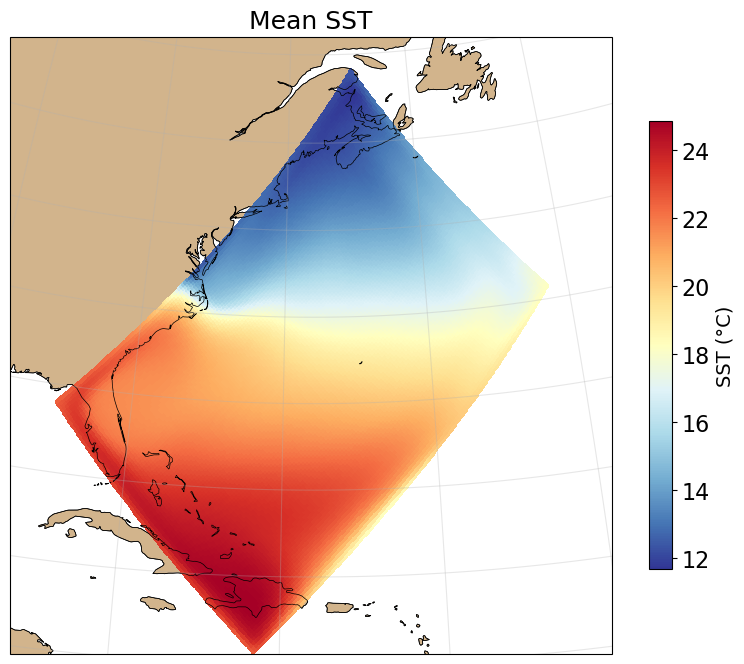

In [3]:
sst_mean = sst.mean("time_counter").where(interior)

fig, ax = gyre_map(ds=ds)

pcm = ax.pcolormesh(
    ds.nav_lon.values, ds.nav_lat.values, sst_mean.values,
    shading="auto", cmap="RdYlBu_r", transform=ccrs.PlateCarree(),
)
fig.colorbar(pcm, ax=ax, label="SST (°C)", shrink=0.7)
ax.set_title("Mean SST")
fig.tight_layout()
fig.savefig("../figures/sst_mean.png", dpi=150, bbox_inches="tight")

## SST temporal evolution

Area-weighted domain-mean SST over time.

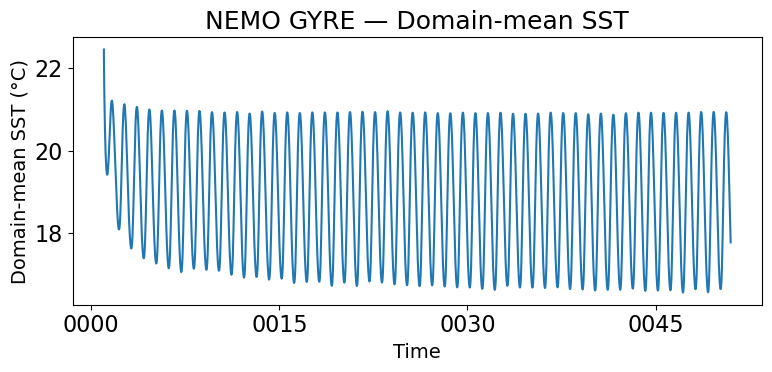

In [4]:
weights = area * interior
sst_domain_mean = sst.weighted(weights).mean(["y", "x"])

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(sst_domain_mean.time_counter, sst_domain_mean)
ax.set_xlabel("Time")
ax.set_ylabel("Domain-mean SST (°C)")
ax.set_title("NEMO GYRE — Domain-mean SST")
fig.tight_layout()

## Meridional SST gradient

Zonal-mean SST as a function of latitude, weighted by cell width `e1t`.

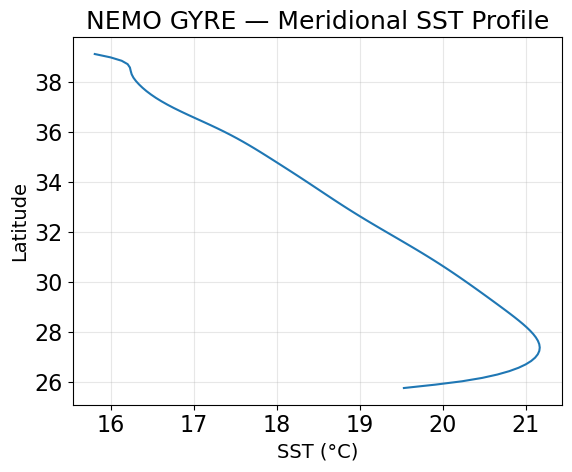

In [5]:
sst_time_mean = sst.mean("time_counter").where(interior)
sst_zonal = sst_time_mean.weighted(e1t).mean("x")

# Representative latitude for each y-row (mid-column value)
lat_1d = ds.nav_lat.isel(x=ds.sizes["x"] // 2)

fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(sst_zonal, lat_1d)
ax.set_xlabel("SST (°C)")
ax.set_ylabel("Latitude")
ax.set_title("NEMO GYRE — Meridional SST Profile")
ax.grid(True, alpha=0.3)
fig.tight_layout()